<a href="https://colab.research.google.com/github/carlomagnani/Stock-Price-Forecaster/blob/main/LSTM_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print("Tensorflow version: "+tf.__version__)

#! pip install pmdarima

# Google file system
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

drive.mount('/GoogleDrive', force_remount=True)

import math



Tensorflow version: 2.8.0
Mounted at /GoogleDrive


In [ ]:
file_2 =   "/GoogleDrive/My Drive/S&P.xlsx"
dataset = pd.read_excel(file_2, sheet_name="ts")

dataset['log_value'] = np.log(dataset['time'])

dataset['lead_ret'] = dataset['log_value'].shift(-5)

dataset.dropna(inplace = True)

model_df = dataset[['log_value', 'lead_ret']]

# split into train and test sets

values = model_df.values
n_train_hours = len(model_df) * 0.60
n_test_hours = len(model_df)*0.2

n_train_hours = round(n_train_hours)
n_test_hours = n_train_hours + round(n_test_hours)

train = values[:n_train_hours, :]
test = values[n_train_hours:n_test_hours, :]
validation = values[n_test_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
validation_X, validation_y = validation[:,:-1], validation[:, -1]

#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)


(14194, 1, 1) (14194,) (4731, 1, 1) (4731,) (4732, 1, 1) (4732,)


Epoch 1/50
444/444 - 8s - loss: 4.4751 - val_loss: 4.6488 - 8s/epoch - 19ms/step
Epoch 2/50
444/444 - 2s - loss: 0.7999 - val_loss: 2.6826 - 2s/epoch - 6ms/step
Epoch 3/50
444/444 - 2s - loss: 0.7264 - val_loss: 2.1509 - 2s/epoch - 6ms/step
Epoch 4/50
444/444 - 3s - loss: 0.5979 - val_loss: 1.8068 - 3s/epoch - 7ms/step
Epoch 5/50
444/444 - 2s - loss: 0.5115 - val_loss: 1.3674 - 2s/epoch - 5ms/step
Epoch 6/50
444/444 - 1s - loss: 0.4363 - val_loss: 1.0617 - 1s/epoch - 3ms/step
Epoch 7/50
444/444 - 1s - loss: 0.3780 - val_loss: 0.8160 - 1s/epoch - 3ms/step
Epoch 8/50
444/444 - 1s - loss: 0.3488 - val_loss: 0.8426 - 1s/epoch - 3ms/step
Epoch 9/50
444/444 - 1s - loss: 0.3026 - val_loss: 0.6821 - 1s/epoch - 3ms/step
Epoch 10/50
444/444 - 1s - loss: 0.2840 - val_loss: 0.7284 - 1s/epoch - 3ms/step
Epoch 11/50
444/444 - 1s - loss: 0.2473 - val_loss: 0.6194 - 1s/epoch - 3ms/step
Epoch 12/50
444/444 - 1s - loss: 0.2258 - val_loss: 0.5137 - 1s/epoch - 3ms/step
Epoch 13/50
444/444 - 2s - loss: 0.1

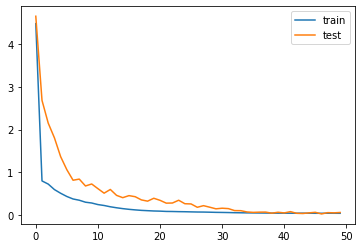

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=0.001)

model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

#model.add(LSTM(10, return_sequences=True))
#model.add(Dropout(0.3))

#model.add(LSTM(10, return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])
#history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error 

yhat = model.predict(validation_X)
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])
validation_X = validation_X.reshape((validation_X.shape[0], validation_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, validation_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
validation_y = validation_y.reshape((len(validation_y), 1))
inv_y = concatenate((validation_y, validation_X[:, 1:]), axis=1)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Validation RMSE: %.3f' % rmse)

Test RMSE: 0.527


(4732, 1)

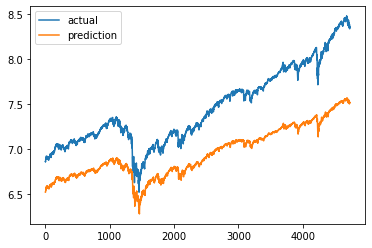

In [ ]:
predictions = pd.DataFrame()

#predictions['date'] = dataset[n_test_hours:, 0]
predictions['pred'] = inv_yhat
predictions['act'] = inv_y

predictions.head()

# plot predictions and actual

plt.plot(predictions['act'], label='actual')
plt.plot(predictions['pred'], label='prediction')
plt.legend()
#plt.show()

In [ ]:
! pip install pmdarima

     |████████████████████████████████| 1.4 MB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 41.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-139866.066, Time=5.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-139865.686, Time=22.60 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-139865.605, Time=12.55 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-139860.180, Time=1.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-139867.431, Time=11.49 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-139865.444, Time=30.54 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-139863.806, Time=7.99 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-139867.336, Time=6.68 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-139863.072, Time=54.22 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-139865.697, Time=22.27 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-139865.015, Time=13.43 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=-139861.735, Time=3.86 sec

Best model:  ARIMA(0,1,0)(1,0,0)[12] intercept
Total fit time: 191.956 seconds


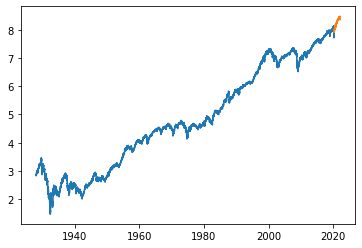

In [ ]:
arima_df = dataset[['date', 'log_value']]

arima_df['date'] = pd.to_datetime(dataset['date'])
arima_df.set_index('date', inplace = True)

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(arima_df)

n_train_hours = len(arima_df) * 0.98
n_train_hours = round(n_train_hours)

train = arima_df[:n_train_hours]
test = arima_df[n_train_hours:]

plt.plot(train)
plt.plot(test)

arima_model = auto_arima(train, start_p = 0, d = 1, start_q = 0, max_p = 5, max_d = 5, max_q = 5, start_P = 0, start_D = 0, start_Q = 0, max_P = 5, max_D = 5, max_Q = 12, m = 12, seasonal = True,
error_action = 'warn', trace = True, suppress_warnings = True, stepwise = True, random_state = 20, n_fits = 50)

In [ ]:
#arima_model.summary()
#prediction = pd.DataFrame(arima_model.predict(n_periods = len(test), index = test.index))
prediction.columns = ['predicted_logprice']

plt.figure(figsize = (8,5))
#plt.plot(train, label = "Training")
plt.plot(test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc = "Left Corner")
#plt.show()

from sklearn.metrics import mean_squared_error
train = arima_df[:n_train_hours]
test = arima_df[n_train_hours:]

print(test)
#test['prediction'] = prediction
#test.dropna(inplace = True)
print("RMSE for the Model is: ", math.sqrt(mean_squared_error(test['log_value'], prediction)))

            log_value
date                 
1984-08-15   5.092522
1984-08-16   5.098463
1984-08-17   5.100720
1984-08-20   5.105582
1984-08-21   5.122952
...               ...
2022-02-25   8.385865
2022-02-28   8.383419
2022-03-01   8.367825
2022-03-02   8.386296
2022-03-03   8.381027

[9466 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'Left Corner'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2ff99bedd0> (for post_execute):


ValueError: ignored

ValueError: ignored

In [ ]:
#train_X, train_y = train[:, :-1], train[:, -1]

train = values[:n_train_hours, :]

#model_df.values

dataset['log_value'] = np.log(dataset['time'])

dataset['lead_ret'] = dataset['log_value'].shift(-5)

dataset.dropna(inplace = True)

model_df = dataset[['log_value', 'lead_ret']]

# split into train and test sets

values = model_df.values
n_train_hours = len(model_df) * 0.60
n_test_hours = len(model_df)*0.2

n_train_hours = round(n_train_hours)
n_test_hours = n_train_hours + round(n_test_hours)

train = values[:n_train_hours, :]
test = values[n_train_hours:n_test_hours, :]
validation = values[n_test_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]

In [ ]:
prediction

,predicted_logprice
0,7.963283
1,7.963796
2,7.963815
3,7.964922
4,7.965119
...,...
468,8.068742
469,8.068963
470,8.069184
471,8.069405
